# Building a CNN model for the CIFAR-10 Dataset

by: Benjamin Fogiel

To better understand this code and the thought process behind it, refer to my medium article **!!Link it!!**

**Getting Started**

Let's gather everything we need
- Clone the GitHub repo and set it as our working directory
- Install PyTorch and import the required packages

In [ ]:
!git clone https://github.com/benfogiel/CIFAR-10-CNN.git

In [ ]:
cd CIFAR-10-CNN/

In [ ]:
!pip3 install torch torchvision -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch
from torchvision import datasets
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import test

In [ ]:
# checking if GPU is available or not
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
# download CIFAR10 dataset
train_ds = datasets.CIFAR10("./data", train=True, download=True)
valid_ds = datasets.CIFAR10("./data", train=False)

# CIFAR-10 Dataset

Let's get familiar with the CIFAR-10 dataset. Here is a sample of first 16 samples in the dataset

In [ ]:
# take the first 16 samples and visualize them in a grid
fig = plt.figure(figsize=(8, 8))
cls_dict = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', \
            5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}
for i in range(16):
    ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    ax.imshow(train_ds[i][0])
    ax.text(1, 4, str(cls_dict[train_ds[i][1]]))
plt.show()

# Preparing the Dataset for Training
Here we'll compile the CIFAR-10 images so they'll be compatible with our network. We'll also sort them out into training, validation, and testing sets.

In [ ]:
class TestData(datasets.VisionDataset):
    
    filepath = "./test.npy"
    
    def __init__(self, root, transform=None):
        super().__init__(root, transform)
        self.data = np.load(self.filepath)
    
    def __getitem__(self, index: int):
        
        img = self.data[index]
        
        if self.transform is not None:
            img = self.transform(img)
            
        return img
        
    def __len__(self):
        return len(self.data)

test_ds = TestData("./data")

The CIFAR-10 images are in PIL format and we need them as tensors. To do this, we will use the PyTorch function ```torchvision.transforms``` that will convert our images to tensors and normalize them.

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_ds.transform = transform
valid_ds.transform = transform
test_ds.transform = transform

train_loader = torch.utils.data.DataLoader(
    train_ds, batch_size=64, shuffle=True
)
valid_loader = torch.utils.data.DataLoader(
    valid_ds, batch_size=1000
)
test_loader = torch.utils.data.DataLoader(
    test_ds, batch_size=1000
)

Let's checkout the shape of one of our tensors

In [ ]:
train_ds[0][0].shape


As you can see, we have 3 channels (representing RGB) and the pixel width and height of each image (32-by-32 pixels). Now that we have our data, let's build our CNN model

# Building our CNN Model
A Convolutional Neural Network (CNN) is a subset of an artificial neural network and is commonly used to analyze images, therefore, it is an appropriate model to use on the CIFAR-10 dataset. 

We'll be using the following layers for **feature extraction**:
- **2D Convolutional Layer:** applies a filter on the image creating a map of activations which we call a "feature map" because, depending on the input parameters, will output highlighted image features. Since we are working with images, we will be using 2 dimensional convolutional layers, however, there are other dimensions as well (ie 4D used in video processing within a 3D space with a temporal dimension). In PyTorch, we create a 2D convolutional layer with ```torch.nn.Conv2d(n_channels, out_channels, kernel_size, padding)```.
-**2D Batch Normalization Layer:** stablizes our previous layer through normaizalization which will also speed up our network. Essentially, it re-centers and re-scales the input. In PyTorch we create a 2D batch normalization layer with ```torch.nn.BatchNorm2d(num_features)``` where ```num_features``` is the number of output channels of the previous layer.
-**Rectified Linear Unit (ReLU):** is an activation function that is essentially used to decide the relationships between features. They are typically used after a convolutional layer because the convolutional layer will provide a feature map for the ReLU function to sift through. In PyTorch we apply the ReLU function by calling ```torch.nn.ReLU()```.
-**2D Max Pooling Layer:** will highlight features by brightening the image. It does this by selecting the max values within a specified pool which will reduce the convolutional size speeding up our network. In PyTorch, we create a 2D max pooling layer by calling ```torch.nn.MaxPool2d(kernel_size, stride)```.
-**Dropout Layer:** is primarily used to prevent overfitting. It does this by randomly setting a fraction of values to 0. This fraction is determined by a probability parameter (ie p=0.3, 30% of the values will be set to 0). In PyTorch, we build a dropout layer by calling ```torch.nn.Dropout(p)```.


For **image classification** we build a fully connected layer that will take our features from the convolutional layers and output predictions for each class. For this, we will use Dropout, ReLU, and Linear layers. The Linear layer simply performs matrix math to linearly transform the shape and provide us with probabilities of each feature. 

Note: to explore all of the neural network layers that are available on PyTorch, refer to their [documentation](https://pytorch.org/docs/stable/nn.html).

Here is our network built with PyTorch (why is it structured like this? Read my medium article!):

In [ ]:
class ConvNet(nn.Module):

    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.01),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        # flatten
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

convnet = ConvNet().to(device)

**Visualizing Our Network**

Here is a diagram of our network:
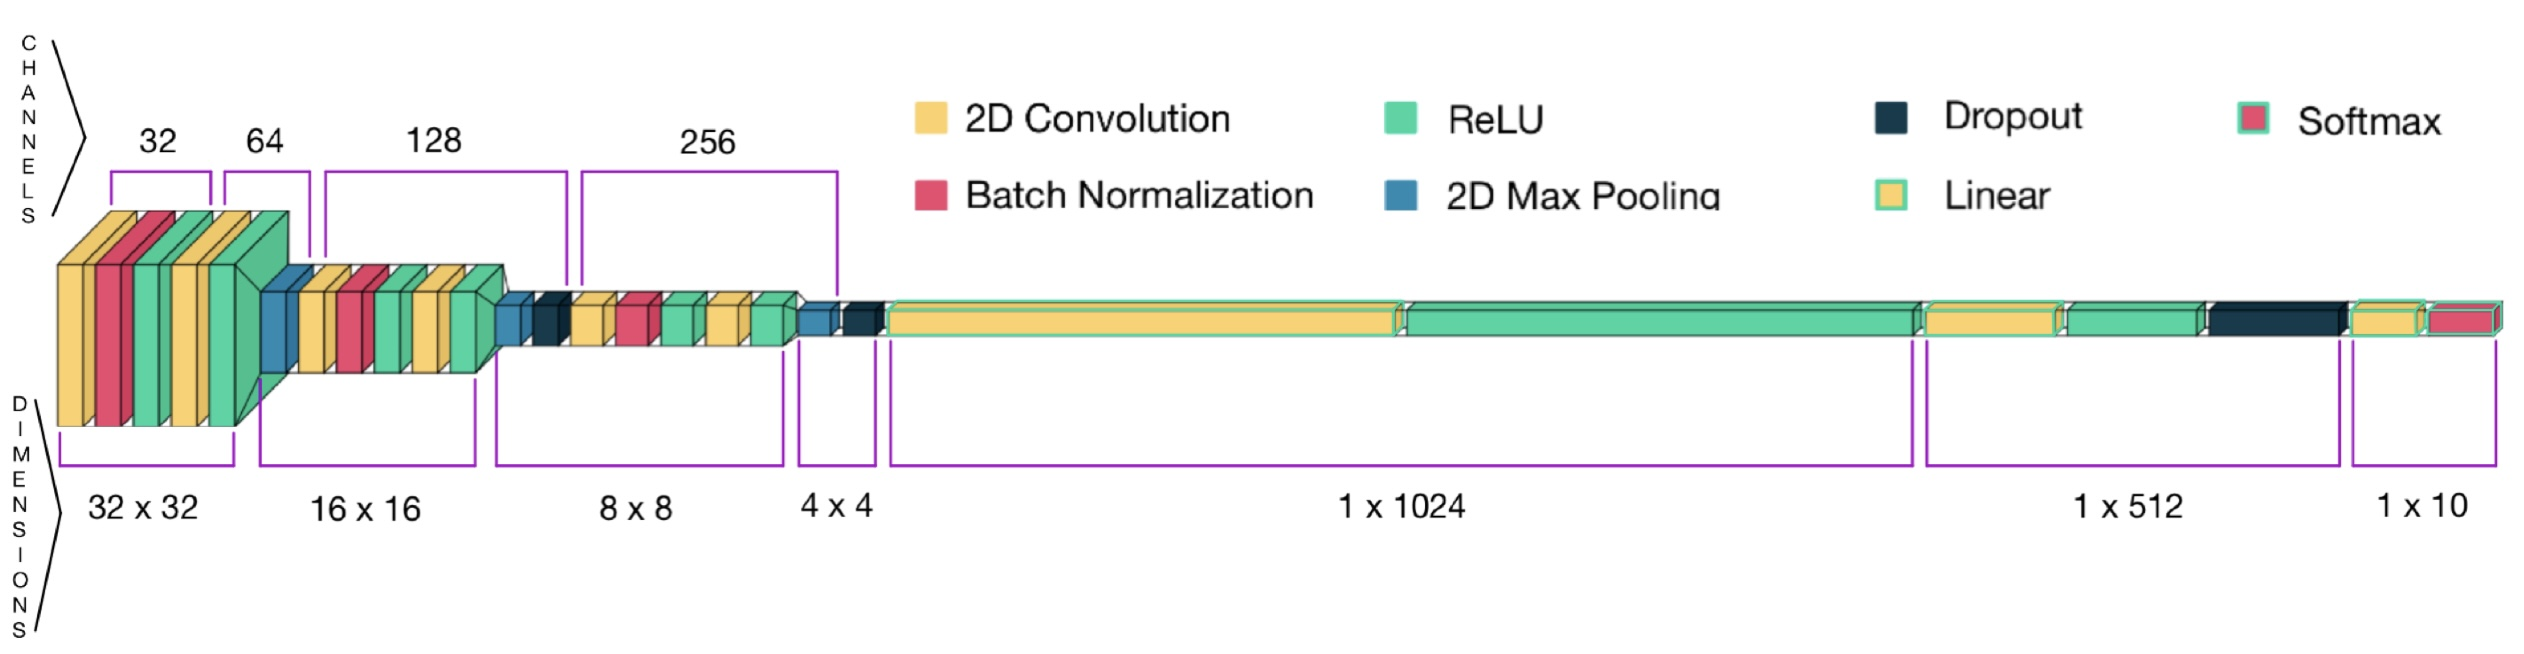

The channel and dimension shapes are the output sizes of our layers. Note that we end up with an output size of 1x10 which is what we want since the CIFAR-10 dataset has 10 classes. So each element refers to a class

We can use PyTorch to give us a summary of our model (less pretty but it's a quick way to get a summary of our model):

In [ ]:
from torchsummary import summary
summary(convnet,input_size=(3,32,32))

**Choosing Our Optimizer**

Now we need to choose our optimizer. Imagine that the model that we built in the previous step is the Sierra mountain range. When we train our network, we will be randomly placed at some point among this vast mountain range. Our goal is to reach a very low point (preferably Death Valley, however, you will almost never get to the lowest point) and our optimizer will choose the path we take to get from our initial to final point.

There are quite a few optimizers to choose from, let's look at the most popular:
- Gradient Descent (GD): Finds the path of steepest descent and steps in that direction. This method is costly and is often not used for big datasets.
- Stochastic Gradient Descent (SGD): Like GD, however, it randomly shuffles the data at each iteration to determine the approximate minima. Although this calls for more iterations than GD, it is less costly.
- Adaptive Gradient Descent (Adagrad): What sets Adagrad from other GD alorithms is it's ability to adjust it's learning reate for each iteration. This works well for data sets with high variability and tends to converge at a fast rate. The main drawback is that in some cases, the learning rate will decrease to such an extent that it will get stuck and essentially stop learning.
- Adaptive Moment Estimation (ADAM): similar to SGD differing by updating it's learning rate parameters of each weight in the network. This results to faster convergence and low costs. ADAM is extremely popular and used for most applications. One of the downsides is that it is built for speed and tends to fall short when generalizing the data whereas SGD, although more costly, is better a data generalization.

If you would like to dive deeper into these optimizers, [this](https://www.analyticsvidhya.com/blog/2021/10/a-comprehensive-guide-on-deep-learning-optimizers) acticle will do you well.

For this tutorial, we will choose SGD. Although it requires more compute than ADAM, our dataset not complex enough to worry about this. If you are willing to sacrafice compute, SGD will generally provide more accurate results. We will also use momentum which essentially exagerates the magnitude of each step taken by the optimizer. When using momentum, it is generally a good idea to use a small learning rate value because with bigger steps, we might overshoot the optimum so decreasing the learning rate is one way of compensating for this (we'll be using 0.01).

Feel free to vary the parameters (learning rate, momentum, etc.) and try out other optimizers to see how well (or poorly) they fair with SGD. [Here](https://pytorch.org/docs/stable/optim.html) is the PyTorch documentation listing the available optimizers and their parameters.

In [ ]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(convnet.parameters(), lr=0.01, momentum=0.9)

# Training and Validation

Here is our training function. This will take all the images in our training set and propogate forward and backwards through our network. Then, it will run our optimizer to generate predictions. The epoch number, running loss, and percision is printed out after each epoch.

In [ ]:
def train(epoch, model, trainloader, criterion, optimizer):
    model.train()
    running_loss, total, correct = 0.0, 0, 0
    for i, data in tqdm(enumerate(trainloader, 0)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # compare predictions to ground truth
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # gather statistics
        running_loss += loss.item()
        
    running_loss /= len(trainloader)
    
    print('Training | Epoch: {}| Loss: {:.3f} | Accuracy on 50000 train images: {:.1f}'.format \
          (epoch+1, running_loss, 100 * correct / total))

Here is our validation function. This will take all the images in our validation set (completely unique from our training set) and the weights generated while training to make predictions. The precision score is then printed which reflects the general accuracy of our model because these images are ones that our network has never seen before.

In [ ]:
def validate(epoch, model, valloader, criterion):
    model.eval()
    running_loss, total, correct = 0.0, 0, 0
    for i, data in tqdm(enumerate(valloader, 0)):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # forward
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # compare predictions to ground truth
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # gather statistics
        running_loss += loss.item()
        
    running_loss /= len(valloader)
    
    print('Validation | Epoch: {}| Loss: {:.3f} | Accuracy on 10000 val images: {:.1f}'.format \
          (epoch+1, running_loss, 100 * correct / total))

**Running Our Network**

This cell below will run all of our data through our network a given number of times (denoted by the number of epochs). Obviously, the higher number of epochs, the longer our network will train for BUT this does not equate to a smarter network. If ran for too long, we can experience overfitting. This is where our network essentially memorizes the trainning data, so when it comes to validating the results (with a completely new set of data), it doesn't do well because it lost its ability to generalize. On the other hand, trainning too little will cause underfitting where your network will over generalize resulting to poor accuracy. Therefore, we need to find the sweet spot between the two.

For this tutorial, we'll use 50 epochs but feel free to play around with this number.

In [ ]:
for epoch in range(50):
    train(epoch, convnet, train_loader, criterion, optimizer)

# validating
validate(epoch, convnet, valid_loader, criterion)

References:
- https://pytorch.org/docs/stable/index.html
- https://www.analyticsvidhya.com/blog/2021/10/a-comprehensive-guide-on-deep-learning-optimizers/#:~:text=Gradient%20Descent%20Deep%20Learning%20Optimizer,to%20achieve%20the%20local%20minimum.
- https://pytorch.org/docs/stable/nn.html
